# Model Exploration

I will use the same architecture than the first model,
but will use Tensorflow Dataset instead of ImageDataGeneretor
and threading 

## Imports

In [1]:
# Generics dependencies
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import randint
from glob import glob

# Tensorflow dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Dropout, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.config.experimental import list_physical_devices, set_memory_growth
from tensorflow.config.threading import set_inter_op_parallelism_threads

import tensorflow as tf
import tensorboard


### Configure GPU

[Procedure for handling GPU](https://www.tensorflow.org/install/gpu)

In [2]:
gpus = list_physical_devices('GPU')
print(gpus)

for gpu in gpus:
    set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-08-05 15:33:45.138217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 15:33:45.175831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 15:33:45.176081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Multithreading

In [3]:
num_threads = 8
set_inter_op_parallelism_threads(num_threads)

### Data samples

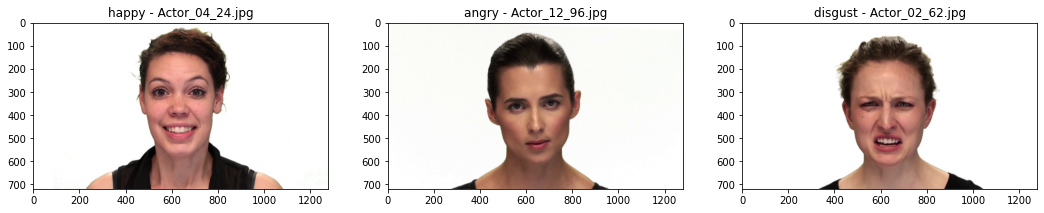

In [4]:

train_files =  glob('../data/03/original_size/train/*/**.jpg')
test_files =  glob('../data/03/original_size/test/*/**.jpg')

train_length = len(train_files)
plt.figure(figsize=(18, 4))

for i in range(3):
    file = train_files[randint(0, len(train_files) -1 )]
    title_base = ' - '.join(file.split('/')[-2:])
    image = mpimg.imread(file)
    ax = plt.subplot(1, 3, i + 1)
    plt.title(title_base)
    plt.imshow(image)    
plt.show()

# Creating datasets

In [5]:
from functions import configure_for_performance

data_folder = '../data/03/original_size'
base_dim = 48
batch_size = 64
seed = 1111

datasets = []

for split in ['train', 'val', 'test']:
    ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(data_folder, split),
        labels='inferred',
        label_mode='categorical',
        color_mode='grayscale',
        batch_size=batch_size,
        image_size=(base_dim, base_dim),
        shuffle=True,
        seed=seed,
    )
    # ds = configure_for_performance(ds)
    datasets.append(ds)
    
train_ds, val_ds, test_ds = datasets

Found 18225 files belonging to 8 classes.
Found 2275 files belonging to 8 classes.
Found 2287 files belonging to 8 classes.


In [23]:
%xdel datasets

## 1st CNN + Tensorflow Datasets and multithreading
### building model 

In [7]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=(base_dim, base_dim, 1)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                        

### Set callbacks

In [2]:
exp_name = 'ravdess_ds_threads'

tensorboard_cb = TensorBoard(
    os.path.join('../models/logs/', exp_name), 
    histogram_freq=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

callbacks = [
    tensorboard_cb,
    reduce_lr_cb,
    early_stopping_cb
]

In [ ]:
face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')

def detect_face(file):
    img = mpimg.imread(file)
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = np.array([list(map(lambda x: 1 if x < 240 else 0, row)) for row in grayscale_image])        
    masked = np.where(mask[...], grayscale_image[...], 0)
    faces = face_detector.detectMultiScale(masked, scaleFactor=1.1, minNeighbors=0)
    if len(faces > 0):
        x, y, w, h = faces[0]
        roi = masked[y:y + h, x:x + w]
        cropped_img = np.expand_dims(cv2.resize(roi, (base_dim, base_dim)), -1)
        return cropped_img
    else:
        cv2.resize(masked)

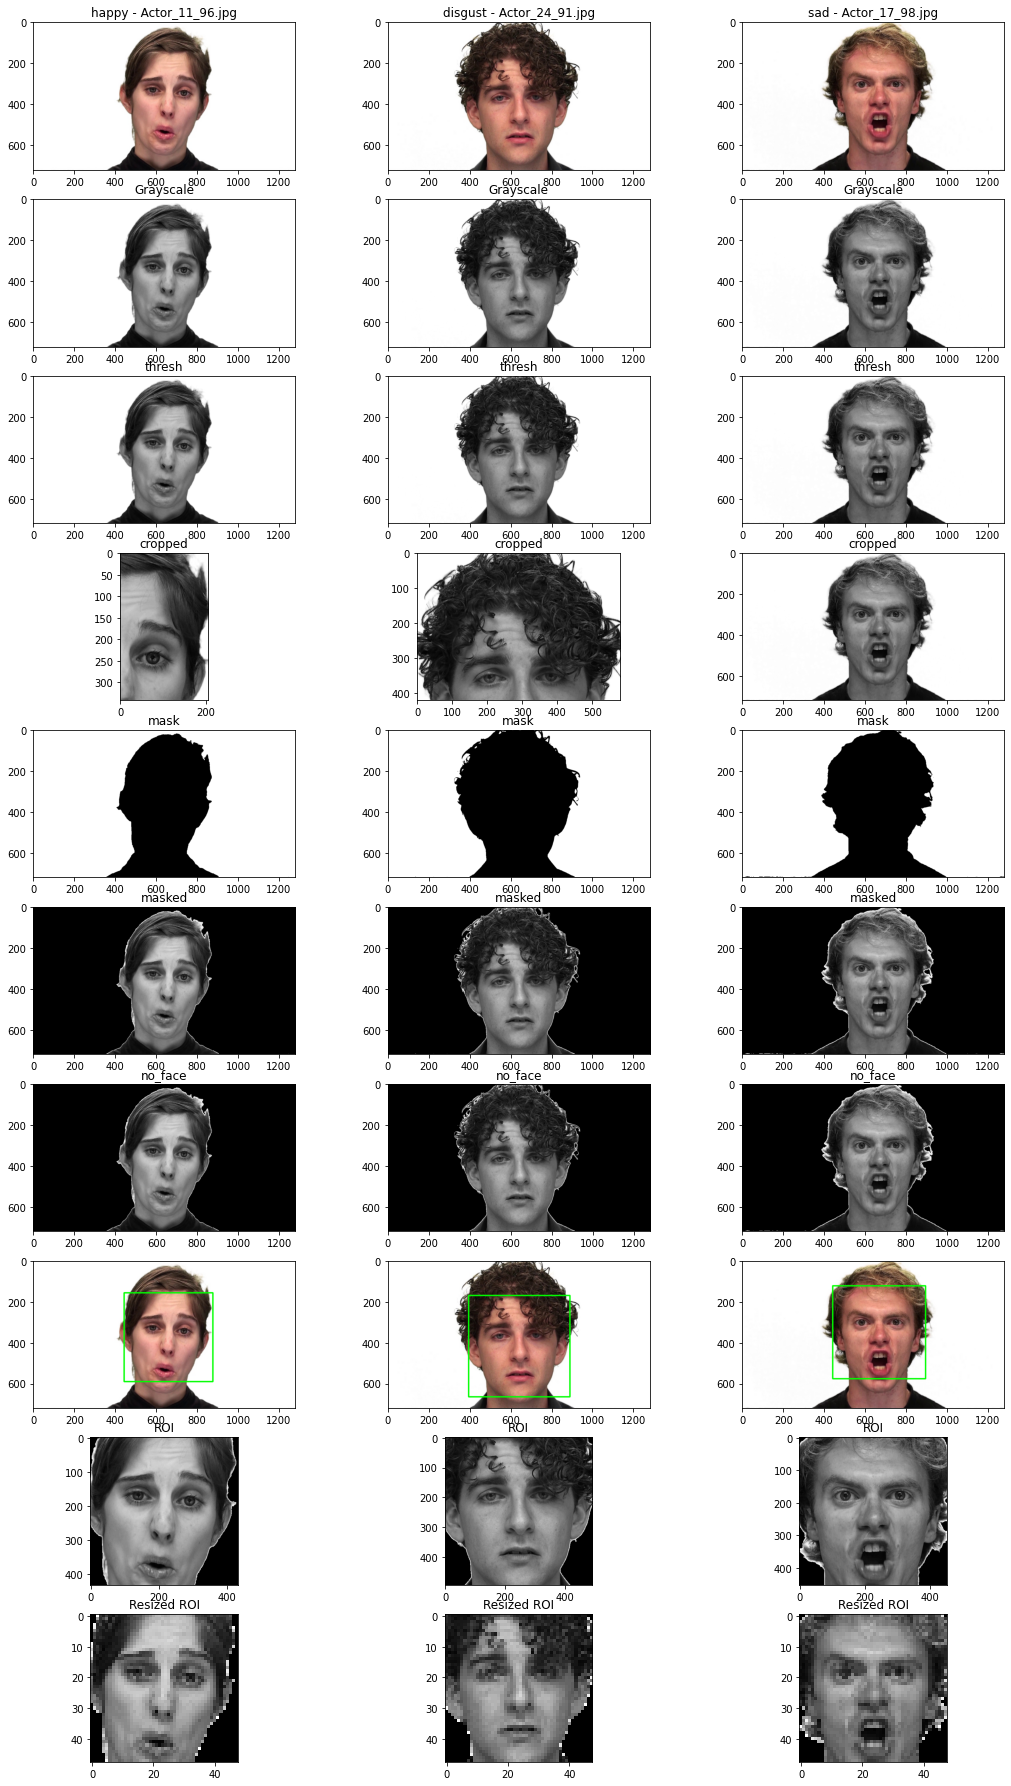

In [10]:
from random import choices
from matplotlib import cm

base_dim = 48
demo_imgs = choices(train_files, k=3)

# plt.figure(figsize=(20, 20))
fig, ax = plt.subplots(10, 3, figsize=(18, 32))
for i in range(len(demo_imgs)):
    title_base = ' - '.join(file.split('/')[-2:])
    file = demo_imgs[i]
    img = mpimg.imread(file)
    
    # Original images
    ax[0][i].set_title(title_base)
    ax[0][i].imshow(img)
    
    # Grayscale images
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    ax[1][i].set_title("Grayscale")
    ax[1][i].imshow(grayscale_image, cmap=cm.gray)
    # Cropped images (face detection)
    gray = cv2.blur(grayscale_image, (11, 11))
    thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)[1]
    ax[2][i].set_title("thresh")
    ax[2][i].imshow(grayscale_image, cmap=cm.gray)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    # c = max(contours, key= cv2.contourArea)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w>100 and h>150:
            break
    cropped = grayscale_image[y:y+h, x:x+w]
    ax[3][i].set_title("cropped")
    ax[3][i].imshow(cropped, cmap=cm.gray)
    face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
    faces = face_detector.detectMultiScale(grayscale_image, scaleFactor=1.1, minNeighbors=5)
    x, y, w, h = faces[0]
    mask = np.array([list(map(lambda x: 0 if x < 240 else 1, row)) for row in grayscale_image])        
    ax[4][i].set_title("mask")
    ax[4][i].imshow(mask, cmap=cm.gray)
    inverted_mask = mask[...] == 255
    masked = np.where(mask[...], 0, grayscale_image[...])
    ax[5][i].set_title("masked")
    ax[5][i].imshow(masked, cmap=cm.gray)
    y_nonzero, x_nonzero = np.nonzero(mask)
    crop_mask = masked[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
    ax[6][i].set_title("no_face")
    ax[6][i].imshow(crop_mask, cmap=cm.gray)
    
    faces_detect = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 5)
    ax[7][i].imshow(faces_detect, cmap=cm.gray)
    roi_masked = masked[y:y + h, x:x + w]
    ax[8][i].set_title("ROI")
    ax[8][i].imshow(roi_masked, cmap=cm.gray)
    
    # Resized cropped images
    cropped_img = np.expand_dims(cv2.resize(roi_masked, (base_dim, base_dim)), -1)
    ax[9][i].set_title("Resized ROI")
    ax[9][i].imshow(cropped_img, cmap=cm.gray)
    
plt.show()

In [121]:
print(mask.min(), mask.max())

0 1


In [10]:
model_info = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=callbacks,
    workers=num_threads,
    use_multiprocessing=True
)

model_json = model.to_json()
if not os.path.exists(f'../models/{exp_name}'):
    os.makedirs(f'../models/{exp_name}/')
with open(f'../models/{exp_name}/model_{base_dim}x{base_dim}.json', 'w') as f:
    f.write(model_json)
    
model.save_weights(f'../models/{exp_name}/model_{base_dim}x{base_dim}.h5')

Epoch 1/50


2022-08-03 22:20:50.237629: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-03 22:20:51.532078: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


285/285 [==============================] - 23s 63ms/step - loss: 2.0491 - accuracy: 0.1635 - val_loss: 1.7909 - val_accuracy: 0.3389 - lr: 0.0010
Epoch 2/50
285/285 [==============================] - 17s 60ms/step - loss: 1.1936 - accuracy: 0.5682 - val_loss: 0.4648 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 3/50
285/285 [==============================] - 18s 60ms/step - loss: 0.4866 - accuracy: 0.8340 - val_loss: 0.1549 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 4/50
285/285 [==============================] - 17s 60ms/step - loss: 0.2694 - accuracy: 0.9083 - val_loss: 0.0894 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 5/50
285/285 [==============================] - 17s 60ms/step - loss: 0.1855 - accuracy: 0.9382 - val_loss: 0.0620 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 6/50
285/285 [==============================] - 17s 60ms/step - loss: 0.1274 - accuracy: 0.9578 - val_loss: 0.0416 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 7/50
285/285 [==============================] - 17s 60ms/step -

In [25]:
predictions = model.predict(
    x=test_ds,
    max_queue_size=10,
    workers=num_threads,
    use_multiprocessing=True,
    callbacks=[tensorboard_cb]
)

36/36 [==============================] - 1s 30ms/step


In [26]:
labels = test_ds.class_names
preds = [labels[np.argmax(prediction)] for prediction in predictions]
trues = [labels[np.argmax(true)] for true in np.concatenate([y for x, y in test_ds], axis=0)]
len(preds), len(trues)

(2287, 2287)

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(trues, preds))
print(confusion_matrix(trues, preds))

              precision    recall  f1-score   support

       angry       0.16      0.16      0.16       306
        calm       0.13      0.13      0.13       293
     disgust       0.13      0.13      0.13       311
     fearful       0.13      0.13      0.13       277
       happy       0.14      0.14      0.14       286
     neutral       0.09      0.09      0.09       259
         sad       0.13      0.13      0.13       287
   surprised       0.12      0.12      0.12       268

    accuracy                           0.13      2287
   macro avg       0.13      0.13      0.13      2287
weighted avg       0.13      0.13      0.13      2287

[[48 43 37 35 32 32 46 33]
 [39 39 39 34 33 47 28 34]
 [36 37 40 48 41 33 39 37]
 [32 39 39 36 36 36 27 32]
 [33 37 40 40 40 26 41 29]
 [38 30 35 25 38 23 39 31]
 [43 32 39 23 33 42 37 38]
 [38 37 44 33 33 20 30 33]]


: 

In [23]:
pred_val = model.predict(
    x=val_ds,
    max_queue_size=10,
    workers=num_threads,
    use_multiprocessing=True,
    callbacks=[tensorboard_cb]
)

36/36 [==============================] - 1s 32ms/step


In [24]:
labels = test_ds.class_names
preds = [labels[np.argmax(prediction)] for prediction in pred_val]
trues = [labels[np.argmax(true)] for true in np.concatenate([y for x, y in ds], axis=0)]
len(preds), len(trues)

(2287, 2287)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(trues, preds))
print(confusion_matrix(trues, preds))

              precision    recall  f1-score   support

       angry       0.12      0.12      0.12       306
        calm       0.11      0.11      0.11       293
     disgust       0.14      0.14      0.14       311
     fearful       0.10      0.10      0.10       277
       happy       0.11      0.11      0.11       286
     neutral       0.10      0.10      0.10       259
         sad       0.12      0.12      0.12       287
   surprised       0.13      0.13      0.13       268

    accuracy                           0.12      2287
   macro avg       0.12      0.12      0.12      2287
weighted avg       0.12      0.12      0.12      2287

[[37 40 38 39 44 28 43 37]
 [53 33 43 28 42 30 31 33]
 [35 34 45 46 44 40 41 26]
 [36 41 48 28 29 27 39 29]
 [35 37 38 38 31 35 36 36]
 [35 37 33 29 24 26 37 38]
 [42 41 39 36 35 27 34 33]
 [34 31 29 30 37 46 26 35]]


In [3]:
from tensorflow.keras.models import model_from_json

base_dim = 48

with open(f'../models/{exp_name}/model_{base_dim}x{base_dim}.json', 'r') as f:
    loaded_json = f.read()

model = model_from_json(loaded_json)
model.load_weights(f'../models/{exp_name}/model_{base_dim}x{base_dim}.h5')


2022-08-05 15:04:11.104450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 15:04:11.161008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 15:04:11.161690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 15:04:11.162795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Preprocessing steps

In [4]:
from random import choices
from matplotlib import cm

demo_imgs = choices(train_files, k=3)

# plt.figure(figsize=(20, 20))
fig, ax = plt.subplots(8, 3, figsize=(18, 32))
for i in range(len(demo_imgs)):
    title_base = ' - '.join(file.split('/')[-2:])
    file = demo_imgs[i]
    img = mpimg.imread(file)
    
    # Original images
    ax[0][i].set_title(f"{title_base} - Original")
    ax[0][i].imshow(img)
    
    # Grayscale images
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    ax[1][i].set_title(f"{title_base} - Grayscale")
    ax[1][i].imshow(grayscale_image, cmap=cm.gray)
    # Cropped images (face detection)
    face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
    faces = face_detector.detectMultiScale(grayscale_image, scaleFactor=1.1, minNeighbors=5)
    x, y, w, h = faces[0]
    mask = np.array([list(map(lambda x: 1 if x < 240 else 0, row)) for row in grayscale_image])        
    ax[2][i].set_title(f"{title_base} - mask")
    ax[2][i].imshow(mask, cmap=cm.gray)
    # masked = cv2.bitwise_not(grayscale_image, grayscale_image, mask)
    masked = np.where(mask[...], grayscale_image[...], 0)
    
    ax[3][i].set_title(f"{title_base} - masked")
    ax[3][i].imshow(masked, cmap=cm.gray)
    contours_roi, hierarchy = cv2.findContours(grayscale_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    img_copy = img.copy()
    for c in contours_roi[1:2]:
        x,y,w,h = cv2.boundingRect(c)
        if w>1000 and h>1000:
            # contours= cv2.contourArea(c)
            contours_img = cv2.drawContours(img_copy, c, -1,  (0,0,255))
            # contours_img = cv2.rectanle(img_copy,(x,y),(x+w,y+h),(255,0,0),1)
    ax[4][i].set_title(f"{title_base} - contours")
    ax[4][i].imshow(img_copy, cmap=cm.gray)
    
    faces_detect = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 5)
    ax[5][i].imshow(faces_detect, cmap=cm.gray)
    roi_masked = masked[y:y + h, x:x + w]
    ax[6][i].set_title(f"{title_base} - ROI")
    ax[6][i].imshow(roi_masked, cmap=cm.gray)
    
    # Resized cropped images
    cropped_img = np.expand_dims(cv2.resize(roi_masked, (base_dim, base_dim)), -1)
    ax[7][i].set_title(f"{title_base} - Resized ROI")
    ax[7][i].imshow(cropped_img, cmap=cm.gray)
    
plt.show()

NameError: name 'train_files' is not defined

In [ ]:
from numpy import ndarray
import pandas as pd 
from tqdm import tqdm

test_files = glob(os.path.join(data_folder, 'test/*/**.jpg'))
columns = ['file', *list(emotions_dict.values()), 'true', 'predicted']

results = pd.DataFrame(columns=columns)
fail_face_recognition = []

for file in tqdm(test_files):
    img = mpimg.imread(file)
    face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=5)
    if len(faces) > 0 :
        x, y, w, h = faces[0]
        roi_gray_img = gray_img[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_img, (48, 48)), -1), 0)
        predictions = model.predict(cropped_img, verbose=0)
    else:
        fail_face_recognition.append(file)
        predictions = model.predict(np.expand_dims(np.expand_dims(cv2.resize(gray_img, (48, 48)), -1), 0), verbose=0)
    predicted  = np.argmax(predictions[0])
    row = [[file], *[[p] for p in predictions[0]], [file.split('/')[-2]], [emotions_dict[predicted]]]
    dict_row = dict(zip(columns, row))
    tmp_results = pd.DataFrame(dict_row)
    results = pd.concat([results, tmp_results])

In [ ]:
n_rows = len(fail_face_recognition) // 3 + 1

plt.figure(figsize=(18, 4 * n_rows))
index = 1

for i in range(len(fail_face_recognition)):
    file = fail_face_recognition[i]
    title_base = ' - '.join(file.split('/')[-2:])
    image = mpimg.imread(file)
    plt.subplot(n_rows, 3, index)
    plt.title(title_base)
    plt.imshow(image)
    plt.subplot(n_rows, 3, index + 3)
    plt.title(f"{title_base} - resized")
    plt.imshow(cv2.resize(image, (48, 48)))
    index += 1
plt.show()

In [ ]:
results.sample(5)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(results['true'], results['predicted']))

In [ ]:
acc = results[results.true == results.predicted_revert].shape[0] / results.shape[0]
print(acc)

### 1st Model results

Train accuracy: 0.9966  
Validation accuracy: 0.9978
Test accuracy : 0.1407

In [ ]:
import seaborn as sns

confusion_matrix(results['true'], results['predicted_revert'])

### Test on video stream

In [ ]:
import os
import cv2
# import skvideo.io
from glob import glob
import numpy as np
from random import randint

videos = glob('../data/test_face_recognition/*.mp4')
rdm_video = videos[randint(0, len(videos) - 1)]
cap = cv2.VideoCapture(rdm_video)
while True:
    success, frame = cap.read()
    if not success:
        break
    frame = cv2.resize(frame, (640, 480))
    face_detector = cv2.CascadeClassifier('../haarcascades/haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y - 50), (x + w, y + h + 10), (0, 255, 0), 4)
        roi_gray_frame = gray_frame[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img, verbose=0)
        # print(dict(zip(emotions_dict.keys(), prediction[0])))
        max_index = int(np.argmax(prediction))
        classes = os.listdir('../data/02/fer_13/train')
        classes.sort()
        cv2.putText(frame, classes[max_index], (x + 5, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.imshow(f'Emotion Detection : {os.path.basename(rdm_video)}', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()